- 이 튜토리얼에서는 CIFAR10 데이터셋을 사용합니다. 여기에는 다음과 같은 분류들이 있습니다: ‘비행기(airplane)’, ‘자동차(automobile)’, ‘새(bird)’, ‘고양이(cat)’, ‘사슴(deer)’, ‘개(dog)’, ‘개구리(frog)’, ‘말(horse)’, ‘배(ship)’, ‘트럭(truck)’. 그리고 CIFAR10에 포함된 이미지의 크기는 3x32x32로, 이는 32x32 픽셀 크기의 이미지가 3개 채널(channel)의 색상로 이뤄져 있다는 것을 뜻합니다.

1. torchvision 을 사용하여 CIFAR10의 학습용 / 시험용 데이터셋을 불러오고, 정규화(nomarlizing)합니다.

2. 합성곱 신경망(Convolution Neural Network)을 정의합니다.

3. 손실 함수를 정의합니다.

4. 학습용 데이터를 사용하여 신경망을 학습합니다.

5. 시험용 데이터를 사용하여 신경망을 검사합니다.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                          shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100.0%

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


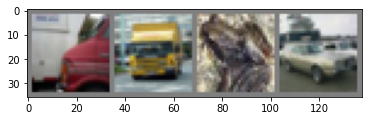

truck truck  frog   car


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5) # 3->6, 5x5
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5) # 6->16, 5x5
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net()

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [8]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' 
                  % (epoch+1, i+1, running_loss/2000))
            running_loss = 0.0
    print('finished')

[1,  2000] loss: 2.170
[1,  4000] loss: 1.820
[1,  6000] loss: 1.675
[1,  8000] loss: 1.601
[1, 10000] loss: 1.519
[1, 12000] loss: 1.468
finished
[2,  2000] loss: 1.404
[2,  4000] loss: 1.369
[2,  6000] loss: 1.367
[2,  8000] loss: 1.301
[2, 10000] loss: 1.295
[2, 12000] loss: 1.262
finished


In [9]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

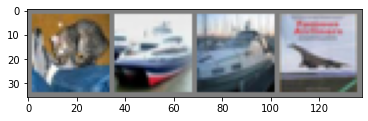

GroundTruth:    cat  ship  ship plane


In [11]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))    

In [12]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
outputs = net(images)

In [13]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    dog  frog   car  deer


In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


In [17]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 75 %
Accuracy of   car : 66 %
Accuracy of  bird : 40 %
Accuracy of   cat : 32 %
Accuracy of  deer : 43 %
Accuracy of   dog : 49 %
Accuracy of  frog : 63 %
Accuracy of horse : 67 %
Accuracy of  ship : 64 %
Accuracy of truck : 59 %


In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')